In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv("sensor-data.csv")
print(data.shape)
print(data.head())
print(data.info())
print(data.describe())

(4100, 9)
   ID                       Datetime  Temperature   Humidity    Pressure  \
0   0  Mon, 20 May 2019 19:08:34 GMT    23.005257  33.060454  972.784433   
1   1  Mon, 20 May 2019 19:08:35 GMT    22.989942  33.095483  972.844472   
2   2  Mon, 20 May 2019 19:08:36 GMT    23.000152  33.080467  972.804446   
3   3  Mon, 20 May 2019 19:08:36 GMT    22.989942  33.105487  972.732905   
4   4  Mon, 20 May 2019 19:08:37 GMT    22.995047  33.105482  972.768675   

   Co2 Gas  PM2.5  PM10 Daytime  
0      626    3.8   8.8   Night  
1      627    3.8   8.9   Night  
2      627    3.8   8.9   Night  
3      626    3.8   8.9   Night  
4      626    3.7   8.3   Night  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           4100 non-null   int64  
 1   Datetime     4100 non-null   object 
 2   Temperature  4100 non-null   float64
 3   Humidity

In [4]:
print(data.isnull().sum())

ID             0
Datetime       0
Temperature    0
Humidity       0
Pressure       0
Co2 Gas        0
PM2.5          0
PM10           0
Daytime        0
dtype: int64


In [10]:
threshold = 0.5 * data.shape[0]
data = data.dropna(thresh=threshold, axis=1)
numeric_cols = data.select_dtypes(include=np.number).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

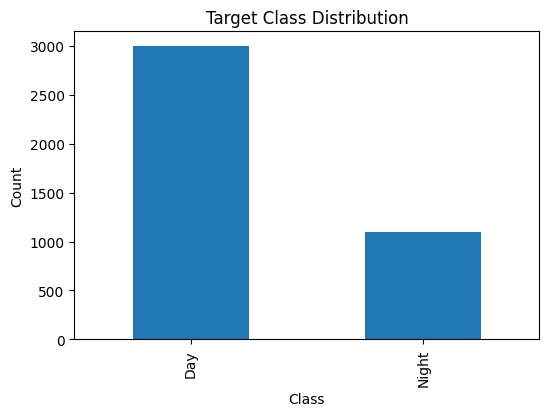

In [11]:
plt.figure(figsize=(6, 4))
data.iloc[:, -1].value_counts().plot(kind='bar')
plt.title("Target Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

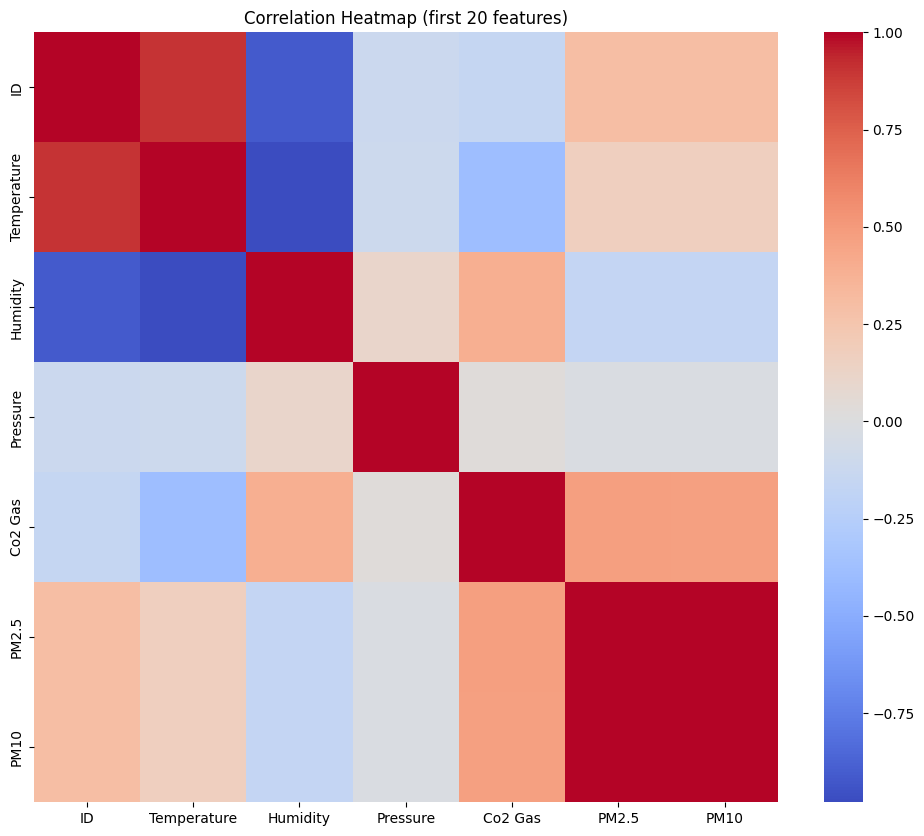

In [13]:
plt.figure(figsize=(12, 10))
numeric_data = data.iloc[:, :20].select_dtypes(include=np.number)
sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap (first 20 features)")
plt.show()

In [15]:
X = data.drop(columns=[data.columns[-1]])  # features
y = data[data.columns[-1]]
object_cols = X.select_dtypes(include=['object']).columns
X = X.drop(columns=object_cols)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB()
}


In [19]:
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))



Training Random Forest...
Accuracy: 1.0000
              precision    recall  f1-score   support

         Day       1.00      1.00      1.00       591
       Night       1.00      1.00      1.00       609

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200


Training SVM...
Accuracy: 1.0000
              precision    recall  f1-score   support

         Day       1.00      1.00      1.00       591
       Night       1.00      1.00      1.00       609

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200


Training Naive Bayes...
Accuracy: 0.9967
              precision    recall  f1-score   support

         Day       0.99      1.00      1.00       591
       Night       1.00      0.99      1.00       609

    accuracy                           1.00      1200
   macro

In [20]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
print("\nBest Random Forest Model")
print(grid_rf.best_params_)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))



Best Random Forest Model
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 1.0000
              precision    recall  f1-score   support

         Day       1.00      1.00      1.00       591
       Night       1.00      1.00      1.00       609

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [21]:
import joblib
joblib.dump(grid_rf.best_estimator_, "best_rf_model.pkl")

['best_rf_model.pkl']

**Conclusion:**
- Random Forest performed the best with optimized hyperparameters.
- SMOTE helped in balancing the target class effectively.
- Feature standardization was necessary to enhance performance.
- Further improvement can be done using feature selection or dimensionality reduction (e.g., PCA).